In [1]:
import os
import shutil
import warnings
import numpy as np
import pandas as pd
import torchaudio
warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import json
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import torch
%matplotlib inline
from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm
from src.test_gen.test_gen_long import  Mel_Provider, Test_Kaggle

In [2]:
TEST_AUDIO_PATH = '/app/_data/test_soundscapes/'
TRAIN_AUDIO_PATH = '/app/_data/train_soundscapes/'
MODEL_PATH = '/app/_data/models/Eff02_2/eff02_2_2.h5'
JSON_PATH = '/app/_data/models/Eff02_2/dict_birds_eff2_02.json'
SAMPLE_RATE = 32000
SEED = 42
IMG_SIZE = 260
N_FFT = 2048
SIGNAL_LENGTH = 5  # seconds
FREQ_MIN = 500
FREQ_MAX = 15000
WIN_LENGHT = 1024
BATCH_SIZE = 128

# test_soundscapes = pd.read_csv('../input/birdclef-2021/test.csv')
# train_soundscape_labels = pd.read_csv('../input/birdclef-2021/train_soundscape_labels.csv')
# test_set_recording_dates  = pd.read_csv('../input/birdclef-2021/test_soundscapes/test_set_recording_dates.csv')
# test= pd.read_csv('../input/birdclef-2021/test.csv')
# sample_submission = pd.read_csv('../input/birdclef-2021/sample_submission.csv')

list_sites = []
for file_name in os.listdir(TEST_AUDIO_PATH):
    if file_name[-4:] == ".txt":
        with open(TEST_AUDIO_PATH + file_name, "r") as f:
            site = f.readlines()
            list_sites.append([file_name.split("_")[0], site[-2:]])
    coord_sites = pd.DataFrame()
    for i in list_sites:
        ids = i[0]
        coord_sites.loc[ids, "longitude"] = i[1][1].split(":")[1].split("\n")[0].split()[0]
        coord_sites.loc[ids, "latitude"] = i[1][0].split(":")[1].split("\n")[0].split()[0]
    coord_sites = coord_sites.astype("float")
    coord_sites["site"] = coord_sites.index
with open(JSON_PATH, 'r') as f:
    dict_birds = json.load(f)
dict_birds_code = {}
for i in dict_birds.keys():
    code = dict_birds[i]
    dict_birds_code[code]=i

In [3]:
def row_wise_f1_score_micro(y_true, y_pred):
    """ author @shonenkov """
    F1 = []
    for preds, trues in zip(y_pred, y_true):
        TP, FN, FP = 0, 0, 0
        preds = preds.split()
        trues = trues.split()
        for true in trues:
            if true in preds:
                TP += 1
            else:
                FN += 1
        for pred in preds:
            if pred not in trues:
                FP += 1
        F1.append(2*TP / (2*TP + FN + FP))
    return np.mean(F1)

In [4]:
def boost_multiple_occurences(
    df,
    labels,
    pred_col,
    out_col="y_pred",
    boost_coef=1.1,
    max_boost_coef=12,
    threshold=0.5,
):
    """
    Boost predictions in file:
        - if something occured once, multiply that class by boost_coef
        - if something occured more than once - keep multiplying until
            boost_coef reaches max_boost_coef
    """

    def _compute_boost_matrix(
        y_preds, labels, threshold, boost_coef, max_boost_coef
    ):
        nocall_ix = labels.index("nocall")
        boost_matrix = np.ones((len(labels)), dtype=np.float64)
        for p in y_preds:
            boost_matrix = boost_matrix * np.where(p > threshold, boost_coef, 1.0)
            boost_matrix = np.clip(boost_matrix, 1.0, max_boost_coef)
            boost_matrix[nocall_ix] = 1.0
        return boost_matrix

    dict_pred = {}
    for filename in set(df["filename"]):  # type: ignore
        file_df = df[df.filename == filename]
        file_y_preds = file_df[pred_col].values
        list_row_id = file_df['row_id'].values
        bm = _compute_boost_matrix(
            file_y_preds,
            labels=labels,
            threshold=threshold,
            boost_coef=boost_coef,
            max_boost_coef=max_boost_coef,
        )

        file_y_preds = bm * file_y_preds
        for i in range(len(list_row_id)):
            dict_pred[list_row_id[i]] = file_y_preds[i]
    return  dict_pred

In [5]:
def pred_from_dict(df, cols, thresh = 0.5, ignore_nocall = True, as_is=False):
    labels = sorted(list(dict_birds.keys()))
    submission = pd.DataFrame(columns = ['row_id', 'birds'])
    for ix in df.index.tolist():
        prediction = df.loc[ix,cols].values
        row_id = df.loc[ix,'row_id']
        nocall_ix = labels.index("nocall")
        submission.loc[ix, 'row_id'] = row_id
        if as_is:
            birds = ' '.join([labels[i] for i in range(len(labels)) if prediction[i]>thresh])
            submission.loc[ix, 'birds'] = birds
        else:
            if ignore_nocall:
                if np.argmax(prediction)!=nocall_ix:
                    birds = ' '.join([labels[i] for i in range(len(labels)) if prediction[i]>thresh])
                    submission.loc[ix, 'birds'] = birds
                else:
                    submission.loc[ix, 'birds'] = 'nocall'
            else:
                if np.argmax(prediction)!=nocall_ix:
                    birds = ' '.join([labels[i] for i in range(len(labels)) if prediction[i]>thresh and i!=nocall_ix])
                    submission.loc[ix, 'birds'] = birds
                else:
                    submission.loc[ix, 'birds'] = 'nocall'
    submission['birds'] = submission['birds'].replace('', 'nocall')
    submission['birds'] = submission['birds'].fillna('nocall')
    return submission


In [6]:
msg_provider = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
    norm_mel_long=False
)

In [7]:
tk = Test_Kaggle(
    path=TRAIN_AUDIO_PATH,
    df_coord_sites = coord_sites,
    mel_provider=msg_provider,
    dict_birds = dict_birds_code,
    n_fft=N_FFT,
    norm_mel_short=True,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    signal_lenght=SIGNAL_LENGTH,
    hop_length=None,
    device="cpu",
)

In [8]:
df = tk.make_df()

In [9]:
df

,filename,audio_id,site,date,duration,month,year,longitude,latitude,sin_month,cos_month,sin_longitude,cos_longitude,norm_latitude
0,51010_SSW_20170513.ogg,51010,SSW,2017-05-13,600.0,5,2017,-76.45,42.47,5.000000e-01,-8.660254e-01,-0.972166,0.234294,0.735944
1,44957_COR_20190923.ogg,44957,COR,2019-09-23,600.0,9,2019,-84.51,10.12,-1.000000e+00,-1.836970e-16,-0.995413,0.095672,0.556222
2,28933_SSW_20170408.ogg,28933,SSW,2017-04-08,600.0,4,2017,-76.45,42.47,8.660254e-01,-5.000000e-01,-0.972166,0.234294,0.735944
3,2782_SSW_20170701.ogg,2782,SSW,2017-07-01,600.0,7,2017,-76.45,42.47,-5.000000e-01,-8.660254e-01,-0.972166,0.234294,0.735944
4,7019_COR_20190904.ogg,7019,COR,2019-09-04,600.0,9,2019,-84.51,10.12,-1.000000e+00,-1.836970e-16,-0.995413,0.095672,0.556222
5,20152_SSW_20170805.ogg,20152,SSW,2017-08-05,600.0,8,2017,-76.45,42.47,-8.660254e-01,-5.000000e-01,-0.972166,0.234294,0.735944
6,31928_COR_20191004.ogg,31928,COR,2019-10-04,600.0,10,2019,-84.51,10.12,-8.660254e-01,5.000000e-01,-0.995413,0.095672,0.556222
7,57610_COR_20190904.ogg,57610,COR,2019-09-04,600.0,9,2019,-84.51,10.12,-1.000000e+00,-1.836970e-16,-0.995413,0.095672,0.556222
8,11254_COR_20190904.ogg,11254,COR,2019-09-04,600.0,9,2019,-84.51,10.12,-1.000000e+00,-1.836970e-16,-0.995413,0.095672,0.556222
9,42907_SSW_20170708.ogg,42907,SSW,2017-07-08,600.0,7,2017,-76.45,42.47,-5.000000e-01,-8.660254e-01,-0.972166,0.234294,0.735944


In [10]:
# audio_path = TEST_AUDIO_PATH
audio_path = TRAIN_AUDIO_PATH
tk = Test_Kaggle(
    path=audio_path,
    df_coord_sites = coord_sites,
    mel_provider=msg_provider,
    dict_birds = dict_birds_code,
    n_fft=N_FFT,
    norm_mel_short=True,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    signal_lenght=SIGNAL_LENGTH,
    hop_length=None,
    device="cpu",
)
list_files = []
boost_pred = False
for files in os.listdir(audio_path):
    if files[-4:] == '.ogg' or  files[-4:] == '.OGG':
        list_files.append(files)
if len(list_files) != 0:
    model = keras.models.load_model(MODEL_PATH)
    pred_df, predictions = tk.make_prediction(tk.make_df(), model, thresh=0.5)
    prediction_values = pd.DataFrame(predictions).T
    prediction_values['row_id'] = prediction_values.index
    if boost_pred:
        prediction_for_boost = pred_df[['row_id', 'filename']].merge(prediction_values, on='row_id')
        columns_before_boost = [i for i in prediction_for_boost.columns.tolist() if i!= 'row_id' and i!='filename']
        dict_pred = boost_multiple_occurences(prediction_for_boost,pred_col = columns_before_boost, labels = sorted(list(dict_birds.keys())))
        df = pd.DataFrame(dict_pred).T
        df['row_id'] = df.index
        columns_boost = [i for i in df.columns.tolist() if i!= 'row_id' and i!='filename']
        submission = pred_from_dict(df, cols = columns_boost, thresh = 0.5, ignore_nocall = True, as_is=False)
    else:
        columns = [i for i in prediction_values.columns.tolist() if i!= 'row_id']
        submission = pred_from_dict(prediction_values,cols = columns,thresh=0.45, ignore_nocall=True, as_is=False)
# else:
#     submission = sample_submission.copy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [12]:
submission

,row_id,birds
51010_SSW_5,51010_SSW_5,grycat
51010_SSW_10,51010_SSW_10,grycat
51010_SSW_15,51010_SSW_15,woothr
51010_SSW_20,51010_SSW_20,norfli
51010_SSW_25,51010_SSW_25,norfli
...,...,...
7843_SSW_580,7843_SSW_580,nocall
7843_SSW_585,7843_SSW_585,nocall
7843_SSW_590,7843_SSW_590,nocall
7843_SSW_595,7843_SSW_595,nocall


In [14]:
prediction_values.to_csv('/app/src/test_gen/prediction_values.csv')
submission.to_csv('/app/src/test_gen/submission.csv')

In [13]:
prediction_values = pd.read_csv('/app/src/test_gen/prediction_values.csv', index_col=[0])
submission= pd.read_csv('/app/src/test_gen/submission.csv', index_col=[0])

In [14]:
submission

,row_id,birds
51010_SSW_5,51010_SSW_5,grycat
51010_SSW_10,51010_SSW_10,grycat
51010_SSW_15,51010_SSW_15,woothr
51010_SSW_20,51010_SSW_20,norfli
51010_SSW_25,51010_SSW_25,norfli
...,...,...
7843_SSW_580,7843_SSW_580,nocall
7843_SSW_585,7843_SSW_585,nocall
7843_SSW_590,7843_SSW_590,nocall
7843_SSW_595,7843_SSW_595,nocall


In [19]:
corr_matrix = prediction_values.corr().fillna(0)
list_corr = []
for ix in corr_matrix.index.tolist():
    for col in corr_matrix.columns:
        if corr_matrix.loc[ix, col] >= 0.75 and ix!=col:
            list_corr.append([ix,col,corr_matrix.loc[ix, col]])
df_corr = pd.DataFrame(list_corr, columns = ['bird1', 'bird2', 'coeff'])

# dict_birds_with_big_cc = pd.DataFrame(columns= df_corr.columns)
# for bird in df_corr['bird1'].unique().tolist():
#     if df_corr[df_corr['bird1']==bird].shape[0] ==1:
#         dict_birds_with_big_cc = pd.concat([dict_birds_with_big_cc, df_corr[df_corr['bird1']==bird]], axis=0, ignore_index=True)
#     else:
#         m = df_corr[df_corr['bird1']==bird]['coeff'].max()
#         dict_birds_with_big_cc = pd.concat([dict_birds_with_big_cc, df_corr.query('bird1==@bird and coeff==@m')], axis=0, ignore_index=True)
# dict_birds_with_big_cc = dict(dict_birds_with_big_cc[['bird1','bird2']].values)

<AxesSubplot:>

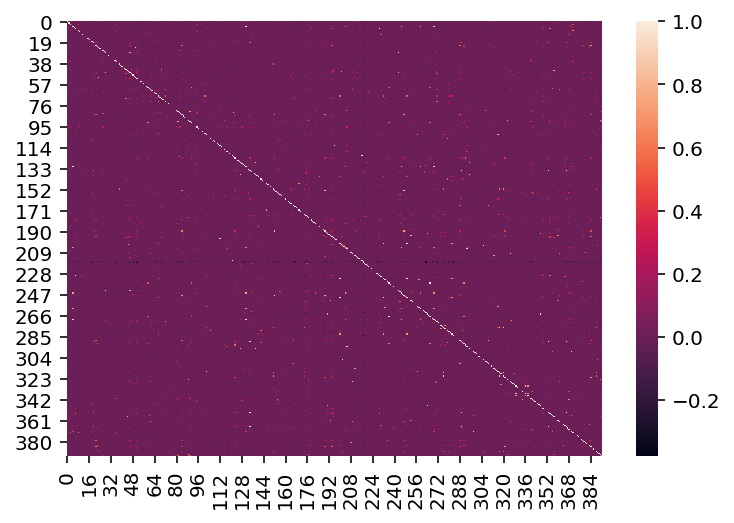

In [18]:
import seaborn as sns
sns.heatmap(corr_matrix)

In [20]:
df_corr

,bird1,bird2,coeff
0,4,131,0.999523
1,4,245,0.758812
2,4,269,0.926994
3,6,229,1.000000
4,23,50,0.883695
...,...,...,...
79,366,134,1.000000
80,366,289,1.000000
81,366,353,1.000000
82,370,298,0.866277
